# **Programming Assignment No. 5**

---


## *Cybersecurity Attack Classification using Random Forest*
### Members:
#####       Logroño, Jessie
#####       Pastores, Efren Jr.
#####       Rabe, Gary Clyde




You are a cybersecurity intern at SecureNet Corp. The company has been experiencing various network security breaches, and your team is tasked with developing a machine learning model to classify different types of cyberattacks.

The senior engineer hands you a dataset of simulated network traffic and says, "We need a robust classifier to detect attacks like DDoS, Botnet, and others. Use your ML skills to build this. Oh, and don’t forget—real-world data is messy; make sure your model can handle it."

Your goal is to preprocess the data and train a Random Forest classifier to identify the type of attack.

##**Dataset**
The dataset cyber_attacks.csv contains the following features:
* protocol_type: Protocol (0: TCP, 1: UDP, 2: ICMP).
* duration: Connection duration (seconds).
* src_bytes: Bytes sent from source.
* dst_bytes: Bytes sent to destination.
* num_packets: Number of packets transmitted.
* num_connections: Number of connections.
* attack_type: Type of attack (Normal, Botnet, DDoS, PortScan, Phishing).

Download the dataset here: [cyber_attacks.csv.](https://drive.google.com/file/d/16CbEic7Jiu2ILNch58v0Z09hRpVYGBfQ/view?usp=sharing)

##**Import Necessary Libraries**


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

#**General Guidelines**

####**1. Load and perform exploratory the data analysis.**




##### **Load the Dataset**

In [74]:
# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset from Drive
dataset_path = '/content/drive/MyDrive/cyber_attacks.csv'
df = pd.read_csv(dataset_path)
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


##### **Exploratory Data Analysis**

In [75]:
# Exploratory Data Analysis (EDA)
print("Dataset Overview:\n", df.head())
print("\nSummary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Overview:
    protocol_type   duration    src_bytes   dst_bytes  num_packets  \
0              1  43.418651  1701.411601  201.794741           42   
1              1   8.587924   409.971403  710.745376           17   
2              1   4.386891   418.478693  559.457816           17   
3              0        NaN          NaN         NaN           11   
4              0   1.061892   494.253699  572.459614           11   

   num_connections attack_type  
0               15      Botnet  
1                6      Normal  
2                5      Normal  
3                3      Normal  
4                3      Normal  

Summary Statistics:
        protocol_type     duration    src_bytes    dst_bytes   num_packets  \
count   10000.000000  9500.000000  9500.000000  9500.000000  10000.000000   
mean        0.506100    84.035480   980.541438  1189.719031     93.993200   
std         0.673653   188.084795  1434.835096  1528.620785    147.278664   
min         0.000000     0.000871     

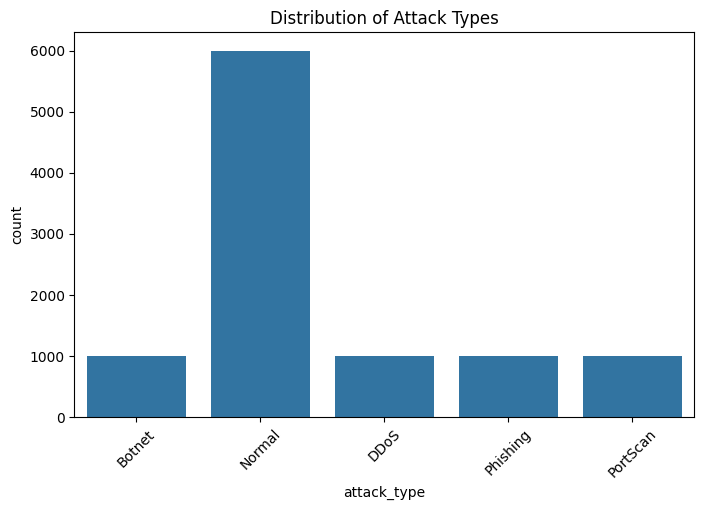

In [76]:
# Visualizing class distribution
plt.figure(figsize=(8,5))
sns.countplot(x=df['attack_type'])
plt.title("Distribution of Attack Types")
plt.xticks(rotation=45)
plt.show()

#####**Encode Categorical Features**

In [77]:
# Encode categorical features
le = LabelEncoder()
df['attack_type'] = le.fit_transform(df['attack_type'])

attack_type_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(attack_type_mapping)

{'Botnet': np.int64(0), 'DDoS': np.int64(1), 'Normal': np.int64(2), 'Phishing': np.int64(3), 'PortScan': np.int64(4)}


In [78]:
# One-hot encoding for protocol_type (TCP, UDP, ICMP)
df = pd.get_dummies(df, columns=['protocol_type'], prefix='protocol_type')

df.rename(columns={
    'protocol_type_0': 'TCP',
    'protocol_type_1': 'UDP',
    'protocol_type_2': 'ICMP'
}, inplace=True)

display(df.head())

,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type,TCP,UDP,ICMP
0,43.418651,1701.411601,201.794741,42,15,0,False,True,False
1,8.587924,409.971403,710.745376,17,6,2,False,True,False
2,4.386891,418.478693,559.457816,17,5,2,False,True,False
3,NaN,NaN,NaN,11,3,2,True,False,False
4,1.061892,494.253699,572.459614,11,3,2,True,False,False


#####**Correlation of Features**

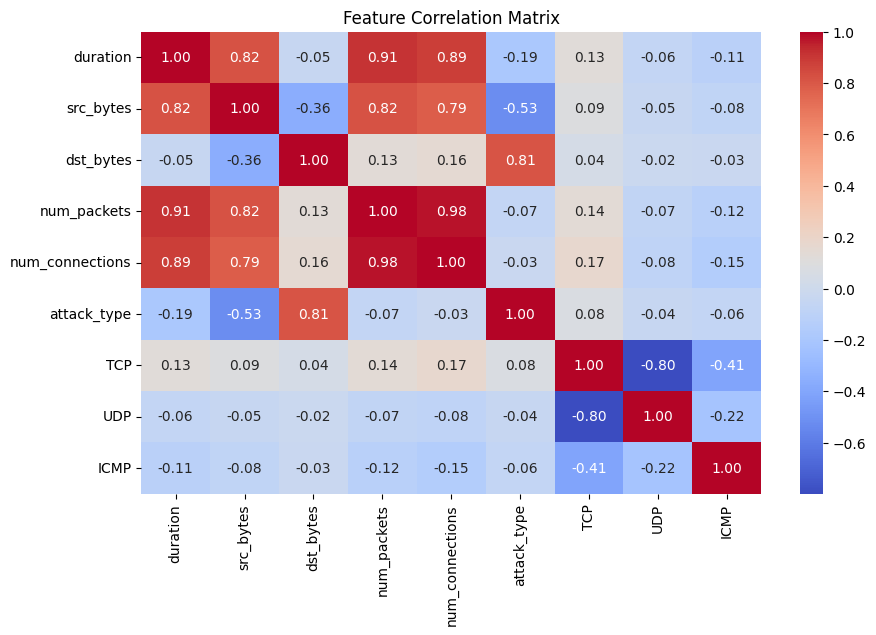

In [79]:
# Visualizing correlation between features
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

####**2. Perform data prepocessing**

#####**Handling of Missing Values**

In [80]:
# Handle missing values
df.fillna(df.median(), inplace=True)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
duration           0
src_bytes          0
dst_bytes          0
num_packets        0
num_connections    0
attack_type        0
TCP                0
UDP                0
ICMP               0
dtype: int64


#####**Splitting Features and Target**

In [81]:
# Split features and target
X = df.drop(columns=['attack_type'])
y = df['attack_type']

print("\nFeatures (X):\n", X.head())
print("\nTarget (y):\n", y.head())


Features (X):
     duration    src_bytes   dst_bytes  num_packets  num_connections    TCP  \
0  43.418651  1701.411601  201.794741           42               15  False   
1   8.587924   409.971403  710.745376           17                6  False   
2   4.386891   418.478693  559.457816           17                5  False   
3   7.121187   500.910972  598.294521           11                3   True   
4   1.061892   494.253699  572.459614           11                3   True   

     UDP   ICMP  
0   True  False  
1   True  False  
2   True  False  
3  False  False  
4  False  False  

Target (y):
 0    0
1    2
2    2
3    2
4    2
Name: attack_type, dtype: int64


####**3. Train a Random Forest Classifier using the preprocessed data to train the model.**

#####**Split Dataset**

In [82]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#####**Define Pipeline**

In [83]:
# Define a pipeline to streamline preprocessing and training
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

#####**Apply Grid Search**

In [84]:
# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],    # Number of trees
    'classifier__max_depth': [10, 20, None],        # Depth of trees
}

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Train final model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate model on test set
y_pred = best_model.predict(X_test)

# Print the best parameters
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}


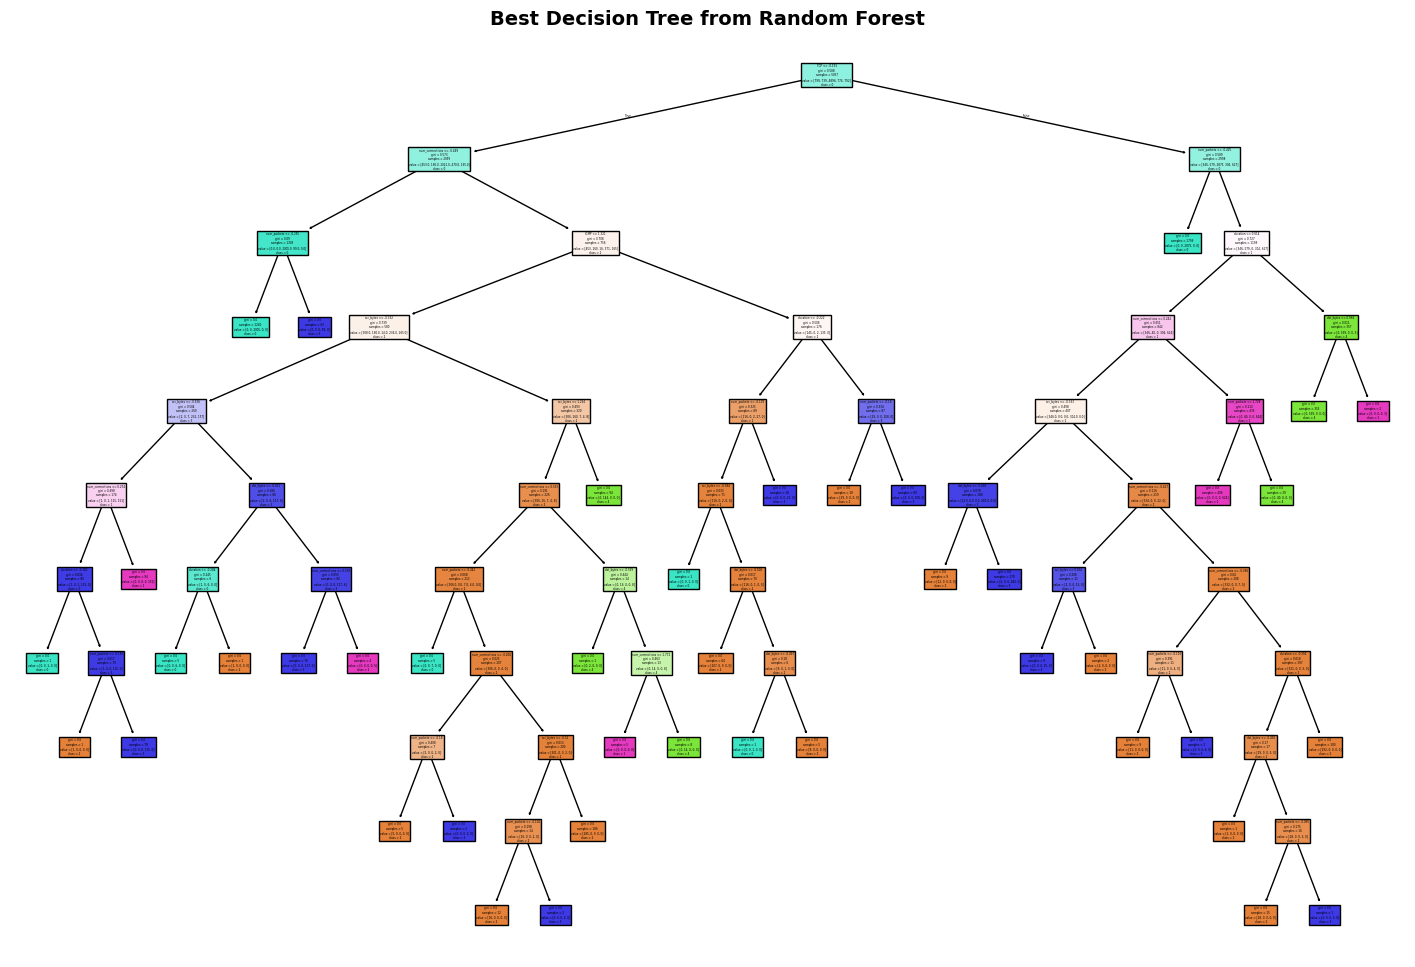

In [85]:
# Function to visualize a decision tree from the trained Random Forest
def visualize_tree_from_pipeline(pipeline, x, y, title="Decision Tree from Random Forest"):
    # Extract the trained Random Forest model from the pipeline
    rf_model = pipeline.named_steps['classifier']

    # Select a single decision tree from the Random Forest (e.g., the first one)
    single_tree = rf_model.estimators_[0]

    # Set figure size for better visualization
    plt.figure(figsize=(18, 12))

    # Obtain feature names and class names
    feature_names = x.columns.to_list()
    class_names = [str(cls) for cls in y.unique()]  # Convert class labels to strings

    # Plot the decision tree
    plot_tree(
        single_tree,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
    )

    # Add title
    plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

# Call the function to visualize the decision tree from the best model
visualize_tree_from_pipeline(best_model, X_train, y_train, "Best Decision Tree from Random Forest")

####**4. Perform feature importance analysis.**

#####**Feature Importance Visualization**

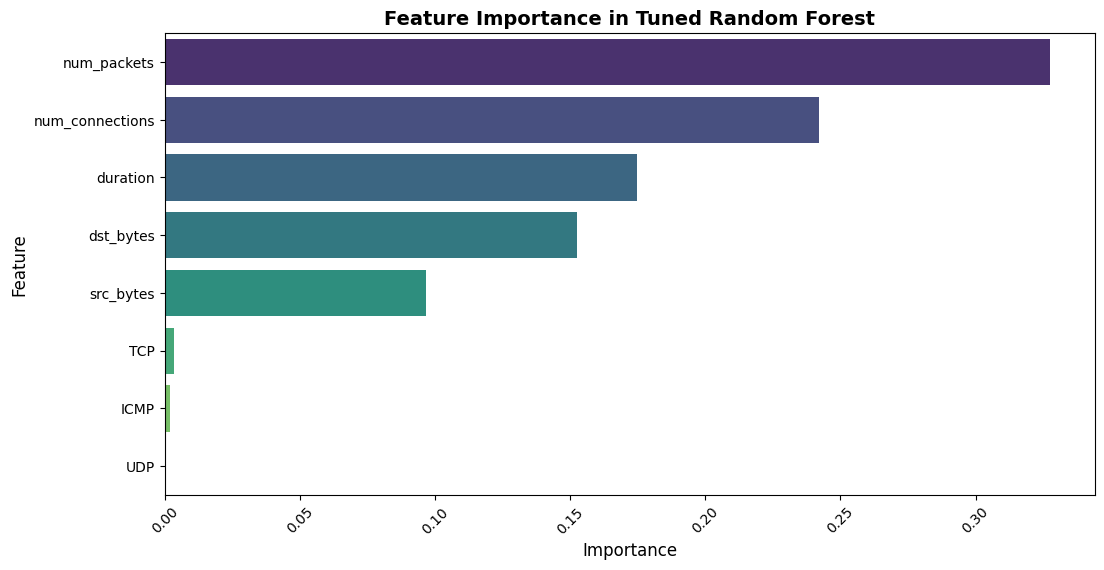

In [86]:
# Extract feature importances from the best Random Forest model
feature_importances = best_model.named_steps['classifier'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance_df['Importance'],
    y=feature_importance_df['Feature'],
    hue=feature_importance_df['Feature'],
    palette='viridis',
    dodge=False
)

# Add labels and title
plt.title("Feature Importance in Tuned Random Forest", fontsize=14, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(rotation=45)
plt.show()


#### **5. Evaluate the model performance and report precision, recall, and F1-score.**

#####**Model Performance**

In [87]:
# Compute and display classification report
report_best = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_best).transpose()

# Display classification report in a readable format
display(report_df.style.set_properties(**{'background-color': 'lightyellow', 'color': 'black'}))

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,200.000000
1,1.000000,1.000000,1.000000,200.000000
2,1.000000,1.000000,1.000000,1200.000000
3,1.000000,1.000000,1.000000,200.000000
4,1.000000,1.000000,1.000000,200.000000
accuracy,1.000000,1.000000,1.000000,1.000000
macro avg,1.000000,1.000000,1.000000,2000.000000
weighted avg,1.000000,1.000000,1.000000,2000.000000


#####**Confusion Matrix**

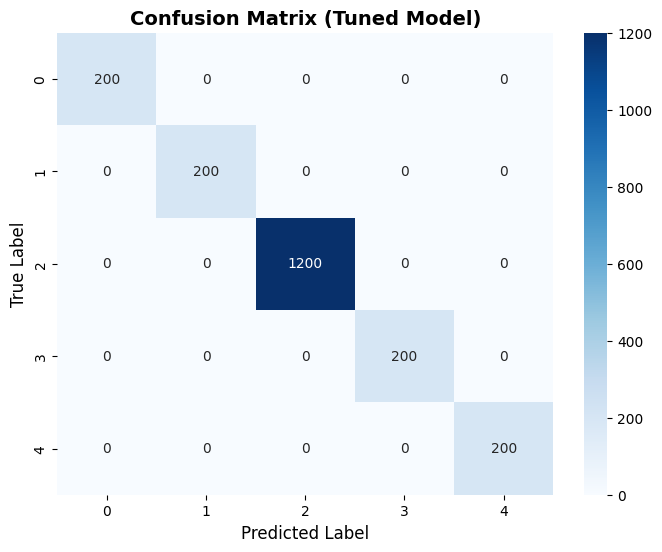

In [88]:

# Compute confusion matrix
conf_matrix_best = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

# Add labels and title
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix (Tuned Model)', fontsize=14, fontweight='bold')
plt.show()

####**Fine-tuning**
We observed that the feature protocol_type (TCP, ICMP, and UDP) has low importance, hence dropping the said feature and proceed with retraining the Random Forest Classifier.

In [89]:
# Feature reduction: Drop TCP, UDP, ICMP columns
X_reduced = X.drop(columns=['TCP', 'UDP', 'ICMP'])

# Split dataset while maintaining class balance
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Define the pipeline
rf_pipeline_reduced = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))  # No fixed n_estimators yet (will be tuned)
])

# Define parameter grid for hyperparameter tuning
param_grid_reduced = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
}

# Perform Grid Search with cross-validation
grid_search_reduced = GridSearchCV(
    rf_pipeline_reduced, param_grid_reduced, cv=5, scoring='accuracy', n_jobs=-1
)

# Train using GridSearchCV
grid_search_reduced.fit(X_train_red, y_train_red)

# Best model after tuning
best_model_reduced = grid_search_reduced.best_estimator_

# Predict using the best model
y_pred_red = best_model_reduced.predict(X_test_red)

# Print the best hyperparameters
print("Best Hyperparameters (Reduced):", grid_search_reduced.best_params_)

Best Hyperparameters (Reduced): {'classifier__max_depth': None, 'classifier__n_estimators': 100}


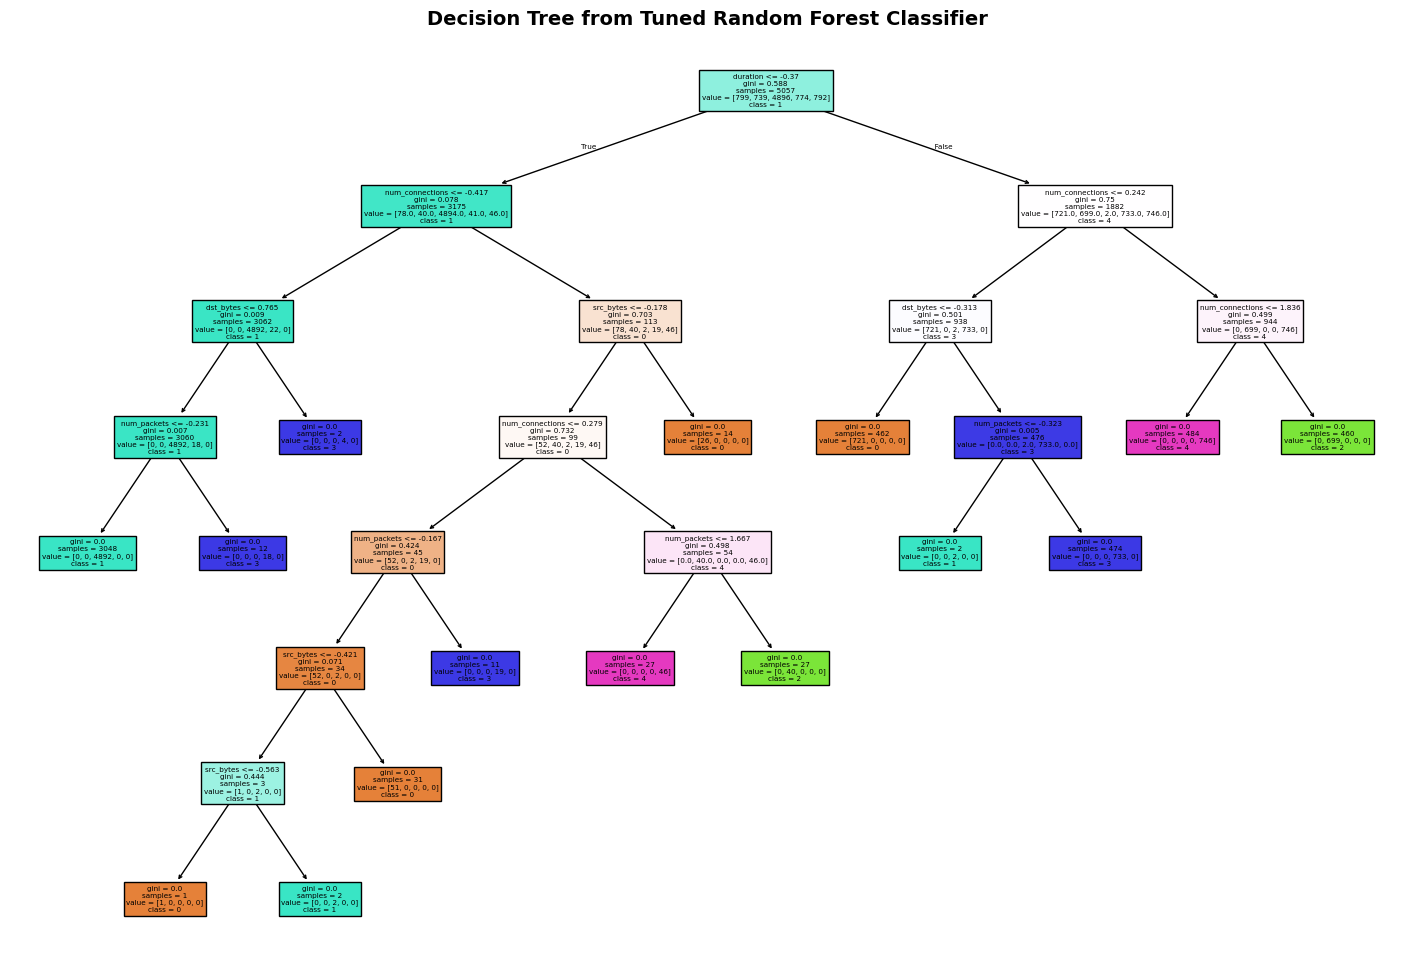

In [90]:
# Visualizing a decision tree from the best-tuned model
def visualize_tree_from_pipeline_reduced(pipeline, x, y, title="Decision Tree from Tuned Random Forest"):

    # Extract trained Random Forest model from the pipeline
    rf_model = pipeline.named_steps['classifier']

    # Select a single tree from the Random Forest (e.g., the first one)
    single_tree = rf_model.estimators_[0]

    # Set figure size for better visualization
    plt.figure(figsize=(18, 12))

    # Obtain feature names and class names
    feature_names = x.columns.to_list()
    class_names = [str(cls) for cls in y.unique()]  # Convert class labels to strings

    # Plot the decision tree with improved visualization
    plot_tree(
        single_tree,
        feature_names=feature_names,
        class_names=class_names,
        filled=True
    )

    # Add title
    plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

# Call the function to visualize the decision tree
visualize_tree_from_pipeline_reduced(best_model_reduced, X_reduced, y, "Decision Tree from Tuned Random Forest Classifier")

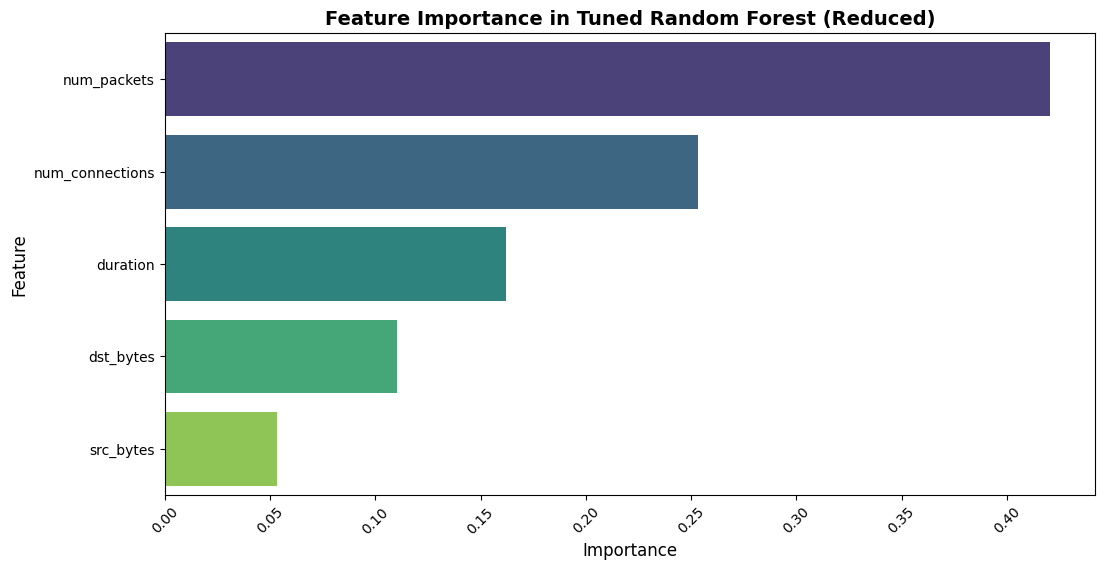

In [91]:
# Extract feature importances after fine-tuning
feature_importances_reduced = best_model_reduced.named_steps['classifier'].feature_importances_
feature_names_reduced = X_reduced.columns

# Create a DataFrame for better visualization
feature_importance_df_reduced = pd.DataFrame({'Feature': feature_names_reduced, 'Importance': feature_importances_reduced})
feature_importance_df_reduced = feature_importance_df_reduced.sort_values(by='Importance', ascending=False)

# Plot feature imporances
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance_df_reduced['Importance'],
    y=feature_importance_df_reduced['Feature'],
    hue=feature_importance_df_reduced['Feature'],
    palette='viridis',
    dodge=False
)

# Add labels and title
plt.title("Feature Importance in Tuned Random Forest (Reduced)", fontsize=14, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [92]:
# Compute and display performance metrics after feature reduction
report_reduced = classification_report(y_test_red, y_pred_red, output_dict=True)
report_df_reduced = pd.DataFrame(report_reduced).transpose()

# Display classification report in a readable format
display(report_df_reduced.style.set_properties(**{'background-color': 'lightyellow', 'color': 'black'}))

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,200.000000
1,1.000000,1.000000,1.000000,200.000000
2,1.000000,1.000000,1.000000,1200.000000
3,1.000000,1.000000,1.000000,200.000000
4,1.000000,1.000000,1.000000,200.000000
accuracy,1.000000,1.000000,1.000000,1.000000
macro avg,1.000000,1.000000,1.000000,2000.000000
weighted avg,1.000000,1.000000,1.000000,2000.000000


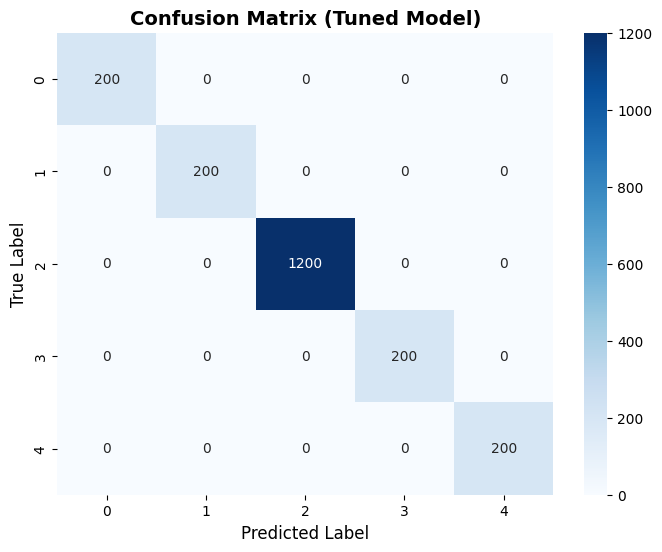

In [93]:
# Compute confusion matrix
conf_matrix_reduced = confusion_matrix(y_test_red, y_pred_red)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_reduced, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_red), yticklabels=np.unique(y_test_red))

# Add labels and title
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix (Tuned Model)', fontsize=14, fontweight='bold')
plt.show()

#**GUIDED QUESTIONS**:
Answer the following questions:


---



####**1. Preprocessing**


*   How did you handle missing values in numerical features?

> To handle missing values in numerical features, we used the following approach: df.fillna(df.median(), inplace=True). It fills the missing values with the median of each column.

*   Why is there a need to encode the protocol_type feature, and which encoding method can be used?

> The protocol_type feature is a categorical feature which Random Forest cannot directly process, hence, we used one-hot encoding it will transform its values into a binary or two-valued logical outcome.   



####**2. Model Training**


*   How did you address class imbalance in the dataset?

> We used stratify=y when splitting the dataset to ensure the consistency of class distribution in both training and test sets.

*   What hyperparameters of the Random Forest did you tune, and why?

> We tuned the n_estimators and max_depth hyperparameters using GridSearchCV to determine the optimal values that enhance model performance.

*   Why is a pipeline useful for this task?

> The pipeline helps with consistent performance of the StandardScaler and RandomForestClassifier. It also helps with the hyperparamater tuning and prevents data leaking.



####**3. Evaluation**


*   Why is accuracy alone insufficient to evaluate this model?

> Accuracy is not always a reliable performance metric, especially in imbalanced datasets. If one attack type appears more frequently, the model may consistently predict that class, resulting in high accuracy while failing to detect less common attack types. This can lead to a significant number of false negatives, making the model ineffective for identifying rare attacks.

*   Which attack type was hardest to classify, and why might this be?

> Based on the classification report, all attack types achieved perfect scores which means no difficulties in classification. However, the minority classes (Botnet, DDoS, Phishing, and Portscan) would be harder to classify in real-life scenarios due to class imbalance.

*   How would you improve the model’s performance on minority classes?

> Just like what we did in this programming assignment, we could balance all the classes by oversampling the minority classes. We could undersample the majority class.

####**4. Interpretation**


*   Which features were most important for classification? Does this align with real-world attack patterns?

> The importance of each feature is listed from most important to least important (based on the feature importance plot):
> *   num_packets: Number of packets transmitted
> *   num_connections: Number of connections
> *   duration: Connection duration (seconds)
> *   dst_bytes: Bytes sent to destination
> *   src_bytes: Bytes sent to source

> These features are consistent with real-world attack behaviors, as network-based anomalies often manifest in traffic volume, session duration, and connection frequency.

*   How would you explain the model’s decision-making process to a non-technical team?

> We explain the model using simple visuals like the decision trees and the feature importance charts that is generated in this laboratory.



####**5. Application**


*   What steps would you take to deploy this model in a real-time network monitoring system?

> To deploy this model, we need a system that processes network traffic in real-time, extracts key features, and feeds them into the trained model for classification. The deployment should include automated retraining using newly validated attack data to keep the model up to date. Integrating it into a CI/CD pipeline ensures continuous improvement and seamless updates. A monitoring dashboard should also be implemented to display predictions and alerts for detected threats.

*   How would you handle new attack types not present in the training data?

> Handling new attack types requires a combination of periodic model retraining and anomaly detection techniques. The system should flag unusual patterns and forward them for cybersecurity validation. Once confirmed as new threats, these samples should be added to the dataset for future training, ensuring the model remains effective against emerging attacks.
